In [8]:
#generic
from pathlib import Path
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import logging 
import importlib

#ML 

#RS 

import geopandas as gpd 
#Project
from src.data.data_loader_rise import DataLoader
import functions

## 1. Preprocessing 

In [2]:
## Inits 
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

base_path = Path(r'D:\Unistra\Malawi\AK')

# main data paths
DATA_FILE_PATH = base_path / "data" / "train_ready" / "malawi_triplet_eos" / "train_rise" / "data.npy"
ID_FILE_PATH = base_path / "data" / "train_ready" / "malawi_triplet_eos" / "train_rise" / "ids.npy"
LABELS_FILE_PATH = base_path / "data" / "train_ready" / "malawi_triplet_eos" / "train_rise" / "labels.npy"
META_FILE_PATH = base_path / "data" / "train_ready" / "malawi_triplet_eos" / "train_rise" / "harmonized_malawi_3857_w_Id" / "harmonized_malawi_3857" / "harmonized_malawi_3857.shp"

META_FILE_PATH_REVISED = base_path / "data"  / "train_ready" / "malawi_triplet_eos" / "train_rise" /"harmonized_malawi_3857_revised" / "harmonized_malawi_3857_revised.shp"

# Satellite band name and mapping to S1/S2 naming wherever possible
BAND_NAME_MAP = {
    'coastal_blue_median': 'COASTALBLUE',
    'blue_median': 'B2',
    'green_i_median': 'GREENI',
    'green_median': 'B3',
    'yellow_median': 'YELLOW',
    'red_median': 'B4',
    'rededge_median': 'REDEDGE',
    'nir_median': 'B8',
    'alpha_median': 'ALPHA'
}
BAND_NAMES = list(BAND_NAME_MAP.keys())
mask_value = 65535


In [3]:
list(BAND_NAME_MAP.values())

['COASTALBLUE', 'B2', 'GREENI', 'B3', 'YELLOW', 'B4', 'REDEDGE', 'B8', 'ALPHA']

In [3]:
data = np.load(DATA_FILE_PATH)
ids = np.load(ID_FILE_PATH)
labels = np.load(LABELS_FILE_PATH)
meta_o = gpd.read_file(META_FILE_PATH)
meta = gpd.read_file(META_FILE_PATH_REVISED)

logger.info(f"Loaded train data {data.shape}")
logger.info(f"Loaded ids data {ids[0]}")
logger.info(f"Loaded labels data {labels[0]}")
logger.info(f"Value counts {meta['Intercrop'].value_counts()}")
logger.info("Loaded polygon data")

meta_selected = meta[meta['Source'] != 'CIMMYT'].reset_index(drop=True)
logger.info("Filtered data according to attribute")
logger.info(f"meta_selected head: {meta_selected.head()}")
logger.info(f"ids shape: {ids.shape}")
logger.info(f"data shape: {data.shape}")


data[data == 9999.0] = mask_value
logger.info("Masked no data values")



INFO:__main__:Loaded train data (636950, 29, 9)
INFO:__main__:Loaded ids data 0
INFO:__main__:Loaded labels data Maize
INFO:__main__:Value counts Intercrop
Maize                                             1555
Maize, Pigeon_Pea                                  653
Maize, Pumpkin                                     193
Soybean                                            158
Groundnut                                          142
                                                  ... 
Maize, Pigeon_Pea, Millet, Rice                      1
Maize, Pigeon_Pea, Pumpkin, Sweet_Potato, Rice       1
Maize, Cowpea, Sweet_Potato, Sorghum                 1
Maize, Pumpkin, Sweet_Potato, Sorghum                1
Beans, Groundnut, Sweet_Potato, Soybean              1
Name: count, Length: 299, dtype: int64
INFO:__main__:Loaded polygon data
INFO:__main__:Filtered data according to attribute
INFO:__main__:meta_selected head:   Main_Ct             Other_Ct                   Intercrop  Year   Source  \
0   

## 2. Feature Engineering 

In [5]:
logger.info('Harmonising features and adding vegetation indices')
dataloader = DataLoader(list(BAND_NAME_MAP.keys()), mask_value)
VIs = {'NDVI': [7, 5] , 'CRI':[3,1]}
data, features, band_name_map = dataloader.make_VIs(data, VIs, BAND_NAMES, BAND_NAME_MAP)

INFO:__main__:Harmonising features and adding vegetation indices


In [6]:
meta

,Main_Ct,Other_Ct,Intercrop,Year,Source,Src_File,Yield,Field_Id,geometry
0,Maize,Pigeon_Pea,"Maize, Pigeon_Pea",2022,Harvest,2022_CC_FB,3.731034483,0,"POLYGON ((3918929.949 -1695251.167, 3918930.50..."
1,Maize,"Pigeon_Pea, Sorghum","Maize, Pigeon_Pea, Sorghum",2022,Harvest,2022_CC_FB,2.487931034,1,"POLYGON ((3885682.872 -1694518.064, 3885679.34..."
2,Maize,"Sesame, Sorghum","Maize, Sesame, Sorghum",2022,Harvest,2022_CC_FB,1.224137931,2,"POLYGON ((3893414.578 -1699699.477, 3893416.80..."
3,Maize,Pigeon_Pea,"Maize, Pigeon_Pea",2022,Harvest,2022_CC_FB,2.033333333,3,"POLYGON ((3883854.262 -1694375.514, 3883853.52..."
4,Maize,None,Maize,2022,Harvest,2022_CC_FB,0.644827586,4,"POLYGON ((3893938.523 -1700011.161, 3893937.59..."
...,...,...,...,...,...,...,...,...,...
4436,Maize,Pigeon_Pea,"Maize, Pigeon_Pea",2023,CIMMYT,CIMMYT_2023,None,4638,"POLYGON ((3955964.748 -1665192.896, 3955979.33..."
4437,Maize,Pigeon_Pea,"Maize, Pigeon_Pea",2023,CIMMYT,CIMMYT_2023,None,4639,"POLYGON ((3956006.718 -1665082.708, 3956024.88..."
4438,Maize,Pigeon_Pea,"Maize, Pigeon_Pea",2023,CIMMYT,CIMMYT_2023,None,4640,"POLYGON ((3956029.094 -1665028.624, 3956038.75..."
4439,Maize,Pigeon_Pea,"Maize, Pigeon_Pea",2023,CIMMYT,CIMMYT_2023,None,4641,"POLYGON ((3956123.512 -1664884.854, 3956154.31..."


In [ ]:
## adding this newly

temperature_files_path = r"D:\Unistra\Malawi\AGROECO\Temperature"
Precipitation_files_path = r"D:\Unistra\Malawi\AGROECO\Precipitation"

shapefile_path = r"D:\Unistra\Malawi\AK\data\train_ready\malawi_triplet_eos\train_rise\harmonised_malawi_3857_revised_reproj\annotated.shp"
gdf = gpd.read_file(shapefile_path)
if not all(gdf.geometry.geom_type == 'Point'):
    gdf['geometry'] = gdf.geometry.centroid
gdf_yeild = gdf[gdf.Yield.notnull()].reset_index(drop = True)
gdf_22 = gdf_yeild[gdf_yeild.Year == 2022].reset_index(drop = True)
gdf_23 = gdf_yeild[gdf_yeild.Year == 2023].reset_index(drop = True)

temp_22 = functions.get_agvar(temperature_files_path , gdf_22,year = 2022,agvar = 'Temperature')
precip_22 = functions.get_agvar(Precipitation_files_path , gdf_22 , year = 2022, agvar = 'Precipitation')
temp_23 = functions.get_agvar(temperature_files_path , gdf_23,year = 2023,agvar = 'Temperature')
precip_23 = functions.get_agvar(Precipitation_files_path , gdf_23, year = 2023, agvar = 'Precipitation')

importlib.reload(functions)
temp_22_agg = functions.apply_aggregation(temp_22, kind = 'mean_median_max_sum_min').reset_index(drop=True)
precip_22_agg = functions.apply_aggregation(precip_22, kind = 'mean_median_max_sum_min').reset_index(drop=True)
temp_22_agg.columns = ['Temperature_'+col for col in temp_22_agg.columns ]
precip_22_agg.columns = ['Precipitation_'+col for col in precip_22_agg.columns ]
gdf_agg_22 = pd.concat([gdf_22 , temp_22_agg, precip_22_agg],axis=1)


temp_23_agg = functions.apply_aggregation(temp_23, kind = 'mean_median_max_sum_min').reset_index(drop=True)
precip_23_agg = functions.apply_aggregation(precip_23, kind = 'mean_median_max_sum_min').reset_index(drop=True)
temp_23_agg.columns = ['Temperature_'+col for col in temp_23_agg.columns ]
precip_23_agg.columns = ['Precipitation_'+col for col in precip_23_agg.columns ]
gdf_agg_23 = pd.concat([gdf_23 , temp_23_agg, precip_23_agg],axis=1)


gdf_eco = pd.concat([gdf_agg_22 , gdf_agg_23],axis=0).reset_index(drop=True)


C:\Users\kashy\AppData\Local\Temp\ipykernel_37524\3324599947.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['geometry'] = gdf.geometry.centroid
100%|██████████| 365/365 [00:06<00:00, 59.77it/s]


In [67]:


gdf_eco.to_csv('fafafafa.csv')


In [7]:
bandvalues = list(band_name_map.values())
df = functions.convert_to_df(data , bandvalues)


In [ ]:
method = 'median'
reduced_data , unique_ids = functions.apply_field_reduction(data , ids , how = 'median')
reduced_df = functions.convert_to_df(reduced_data , bandvalues) 
reduced_df_total = pd.merge(reduced_df.reset_index() , meta , left_on = 'index' , right_on = 'Field_Id')
reduced_df_total['n_crops'] = reduced_df_total.Intercrop.apply(lambda x: len(x.split(',')))
reduced_df_total['Area'] = reduced_df_total.geometry.apply(lambda x: x.area/10000) 



In [9]:
## Visualization 

# 1. Single Field extraction 

# 2. All fields - reduction - ex. Median 



In [ ]:
# Assuming 'df' is your DataFrame with PlanetScope bands
'''
df['NDVI'] = (df['B8'] - df['B4']) / (df['B8'] + df['B4'])  # Normalized Difference Vegetation Index
df['GNDVI'] = (df['B8'] - df['B3']) / (df['B8'] + df['B3'])  # Green NDVI
df['SAVI'] = ((df['B8'] - df['B4']) / (df['B8'] + df['B4'] + 0.5)) * (1.5)  # Soil Adjusted Vegetation Index (L=0.5)
df['EVI'] = 2.5 * (df['B8'] - df['B4']) / (df['B8'] + 6 * df['B4'] - 7.5 * df['B2'] + 1)  # Enhanced Vegetation Index
df['NDWI'] = (df['B3'] - df['B8']) / (df['B3'] + df['B8'])  # Normalized Difference Water Index
df['MSAVI'] = (2 * df['B8'] + 1 - ((2 * df['B8'] + 1)**2 - 8 * (df['B8'] - df['B4']))**0.5) / 2  # Modified SAVI
df['VARI'] = (df['B3'] - df['B4']) / (df['B3'] + df['B4'] - df['B2'])  # Visible Atmospherically Resistant Index
df['RENDVI'] = (df['REDEDGE'] - df['B4']) / (df['REDEDGE'] + df['B4'])  # Red Edge NDVI
df['PRI'] = (df['B3'] - df['B2']) / (df['B3'] + df['B2'])  # Photochemical Reflectance Index

# Optional: Clip to avoid division by zero or overflow
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)
'''


KeyError: 'B8'

In [11]:
median_data , unique_ids = functions.apply_field_reduction(data , ids , how ='median')
median_df = functions.convert_to_df(median_data , bandvalues) 
median_df_total = pd.merge(median_df.reset_index(), meta, left_on='index', right_on='Field_Id')
median_df_total['n_crops'] = median_df_total.Intercrop.apply(lambda x: len(x.split(',')) ) 
median_df_total['Area'] = median_df_total.geometry.apply(lambda x: x.area/10000)
band = 'NDVI' 
band_df = median_df_total[[col for col in median_df_total.columns if band in col]]
band_df['n_crops'] = median_df_total['n_crops']

median_band = band_df.groupby(by = 'n_crops').median()
median_band 



C:\Users\kashy\AppData\Local\Temp\ipykernel_54708\131575805.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  band_df['n_crops'] = median_df_total['n_crops']


,NDVI__0,NDVI__1,NDVI__2,NDVI__3,NDVI__4,NDVI__5,NDVI__6,NDVI__7,NDVI__8,NDVI__9,...,NDVI__19,NDVI__20,NDVI__21,NDVI__22,NDVI__23,NDVI__24,NDVI__25,NDVI__26,NDVI__27,NDVI__28
n_crops,,,,,,,,,,,,,,,,,,,,,
1,0.342186,0.334804,0.314996,0.288769,0.270940,0.276022,0.284296,0.485325,0.559635,0.593222,...,0.423181,0.421352,0.401693,0.380305,0.374603,0.366967,0.358507,0.337298,0.334442,0.324181
2,0.339876,0.333080,0.321586,0.289423,0.274283,0.276515,0.296191,0.470368,0.567537,0.600643,...,0.417128,0.414596,0.399807,0.380478,0.377049,0.370584,0.359447,0.338437,0.331442,0.323136
3,0.337941,0.333542,0.313430,0.285631,0.272306,0.278765,0.296162,0.470982,0.559379,0.591241,...,0.413596,0.414799,0.395781,0.372293,0.374656,0.368523,0.356216,0.334050,0.329337,0.323909
4,0.346003,0.344194,0.330369,0.302584,0.286912,0.285919,0.314876,0.485845,0.583311,0.611943,...,0.420114,0.416283,0.407679,0.386038,0.384157,0.376576,0.367089,0.342309,0.338743,0.332105
5,0.335504,0.332103,0.318665,0.286965,0.275670,0.270205,0.318288,0.459992,0.559448,0.621047,...,0.405763,0.411220,0.389588,0.370348,0.366561,0.364072,0.354652,0.326639,0.320270,0.310270
6,0.332039,0.339100,0.332175,0.284595,0.257836,0.270463,0.282716,0.518424,0.563503,0.678686,...,0.407717,0.380138,0.411545,0.360702,0.356353,0.354919,0.349386,0.338115,0.334418,0.315894
7,0.362271,0.365539,0.360591,0.307101,0.294475,0.282752,0.330877,0.544038,0.680418,0.678339,...,0.445182,0.440948,0.435360,0.399761,0.394967,0.371698,0.360329,0.322554,0.341663,0.308236
8,0.322725,0.324278,0.362327,0.280179,0.285796,0.300383,0.374664,0.541049,0.516828,0.617224,...,0.382721,0.362467,0.359702,0.357468,0.352282,0.358017,0.338400,0.308566,0.304773,0.283350
9,0.300545,0.297964,0.374602,0.251518,0.190091,0.140577,0.283424,0.292963,0.354002,0.000000,...,0.428117,0.415856,0.404179,0.373679,0.370788,0.410485,0.322093,0.309529,0.309704,0.266449


In [12]:
median_df_total.Main_Ct.value_counts()

Main_Ct
Maize           3798
Soybean          185
Groundnut        168
Cowpea            88
Rice              73
Cassava           36
Other             16
Pumpkin           14
Sorghum           12
Millet            11
Sweet_Potato      10
Tobacco            9
Pigeon_Pea         8
Sesame             4
Cowpeas            3
Plantain           2
Potato             1
Beans              1
Cotton             1
Forage             1
Name: count, dtype: int64

C:\Users\kashy\AppData\Local\Temp\ipykernel_54708\4103594621.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['yield_num'] = test.Yield.apply(lambda x: float(x) )


<Axes: xlabel='Area', ylabel='yield_num'>

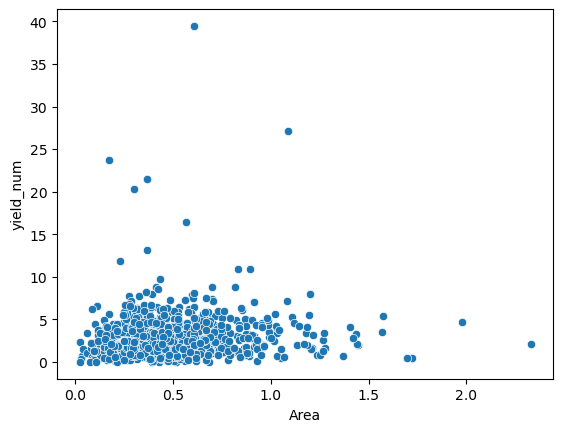

In [13]:
test = reduced_df_total[~ reduced_df_total.Yield.isna()]
test['yield_num'] = test.Yield.apply(lambda x: float(x) )
sns.scatterplot(data = test , x = 'Area' , y = 'yield_num')


In [ ]:
test[test.yield_num > 10]

,index,COASTALBLUE__0,COASTALBLUE__1,COASTALBLUE__2,COASTALBLUE__3,COASTALBLUE__4,COASTALBLUE__5,COASTALBLUE__6,COASTALBLUE__7,COASTALBLUE__8,...,Intercrop,Year,Source,Src_File,Yield,Field_Id,geometry,n_crops,Area,yield_num
39,39,24.798626,24.433409,26.771404,37.394073,41.931297,65.627052,45.175381,39.173935,24.288250,...,"Maize, Cowpea, Pigeon_Pea, Groundnut",2022,Harvest,2022_CC_FB,20.25804598,39,"POLYGON ((3907510.789 -1697567.352, 3907518.58...",4,0.301389,20.258046
68,68,22.458660,23.842529,16.659695,23.828995,30.132746,16.707750,24.048223,0.000000,38.147549,...,Maize,2022,Harvest,2022_CC_FB,11.80172414,68,"POLYGON ((3895067.102 -1684510.303, 3895066.91...",1,0.231162,11.801724
86,86,34.383862,37.742180,53.610737,52.140007,53.361248,104.351151,42.582565,73.863152,36.544113,...,Maize,2022,Harvest,2022_CC_FB,10.86781609,86,"POLYGON ((3901438.297 -1688368.702, 3901440.33...",1,0.834552,10.867816
132,132,39.471050,29.986471,29.838211,47.173294,46.424881,56.978916,55.009193,113.569160,82.572563,...,"Maize, Pigeon_Pea",2022,Harvest,2022_CC_FB,13.12758621,132,"MULTIPOLYGON (((3916567.049 -1673031.437, 3916...",2,0.367778,13.127586
152,152,23.130665,27.193815,24.059958,27.698412,35.793777,50.624561,32.794342,28.456432,39.776016,...,"Maize, Cowpea, Pigeon_Pea, Groundnut",2022,Harvest,2022_CC_FB,16.40977011,152,"POLYGON ((3916079.601 -1685019.771, 3916082.75...",4,0.565929,16.409770
414,414,27.881008,18.015192,22.916594,17.585842,32.728634,30.478334,29.967115,25.798679,34.058838,...,Maize,2022,Harvest,2022_CC_FB,27.12413793,414,"POLYGON ((3774916.725 -1268212.072, 3774913.20...",1,1.089656,27.124138
423,423,21.654310,18.695732,16.926380,16.519823,28.625221,33.231350,35.729534,19.743481,54.574314,...,"Maize, Groundnut, Soybean",2022,Harvest,2022_CC_FB,21.49568966,423,"POLYGON ((3762751.730 -1280077.303, 3762750.80...",3,0.366444,21.495690
424,424,10.806265,17.881687,16.503698,20.502298,23.276955,27.947292,23.478004,24.666452,37.551323,...,"Maize, Groundnut, Soybean",2022,Harvest,2022_CC_FB,21.49568966,424,"POLYGON ((3762751.730 -1280077.303, 3762750.80...",3,0.366444,21.495690
448,448,34.578354,31.458498,25.190332,23.957390,21.801699,21.925188,32.250896,48.833649,26.201687,...,Maize,2022,Harvest,2022_CC_FB,10.92683908,448,"POLYGON ((3759301.180 -1261833.035, 3759301.55...",1,0.895787,10.926839
488,488,48.754135,44.116257,38.858456,54.869404,39.294025,30.496595,58.569710,39.788670,169.981262,...,Maize,2022,Harvest,2022_CC_FB,39.46724138,488,"POLYGON ((3773900.378 -1269365.343, 3773901.86...",1,0.605753,39.467241


In [14]:
import ipywidgets as widgets
from IPython.display import display
test_df = reduced_df_total.iloc[20:40]
ndvi_columns = [f'NDVI__{i}' for i in range(28)]  
def plot_field(index):
    row = test_df.iloc[index]
    
    # Extract NDVI time series
    ndvi_values = row[ndvi_columns].values
    time_points = list(range(len(ndvi_columns)))
    
    # Plot
    plt.figure(figsize=(10, 5))
    plt.plot(time_points, ndvi_values, marker='o')
    plt.title(f' NDVI({method}) Time Series for Plot {index}')
    plt.xlabel('Time Point')
    plt.ylabel('NDVI')
    plt.grid(True)
    plt.show()
    
    # Display metadata
    print(f"Intercrop: {row['Intercrop']}")
    print(f"N_crops: {row['n_crops']}")
    print(f"Area: {row['Area']}")
    print(f'Yield: {row['Yield']}')

    


index_slider = widgets.IntSlider(min=0, max=len(test_df)-1, step=1, description='Plot Index:')
widgets.interact(plot_field, index=index_slider)

interactive(children=(IntSlider(value=0, description='Plot Index:', max=19), Output()), _dom_classes=('widget-…

<function __main__.plot_field(index)>

In [16]:
doe = reduced_df_total.Intercrop.value_counts().index

pd.Series(doe).apply(lambda x: len(x.split(','))).value_counts()


Intercrop
4    93
3    73
5    52
2    37
1    18
6    16
7     7
8     2
9     1
Name: count, dtype: int64

In [17]:
# Find out per- pixel variance across space, plotted across time 


#  fpar , rad rain, soil moisture 
# TapFN  model  

# Evapoptranspiration 
# soil -  landform , topography 

# soybean - groundnut 


In [ ]:
# Basic Yield prediction model 

# 1. Preprocessing , post processing. 

# 2. Feature engineering , selection with ife  

#  You need to calculate cumsum/AOC , means , medians , etc.

# 3. EDA / Pre ML 

# 4. ML and results 


In [12]:
df

,COASTALBLUE__0,COASTALBLUE__1,COASTALBLUE__2,COASTALBLUE__3,COASTALBLUE__4,COASTALBLUE__5,COASTALBLUE__6,COASTALBLUE__7,COASTALBLUE__8,COASTALBLUE__9,...,CRI__19,CRI__20,CRI__21,CRI__22,CRI__23,CRI__24,CRI__25,CRI__26,CRI__27,CRI__28
0,589.0,592.0,627.0,618.0,575.0,622.0,557.0,694.0,396.0,520.0,...,1.189349,1.217228,1.326087,1.277264,1.313346,1.384454,1.277778,1.250000,1.389632,1.370066
1,620.0,584.0,667.0,616.0,582.0,637.0,587.0,717.0,397.0,567.0,...,1.295547,1.240437,1.341748,1.296435,1.254579,1.381526,1.292469,1.272868,1.388350,1.359300
2,631.0,655.0,661.0,682.0,677.0,1169.0,551.0,809.0,566.0,562.0,...,0.748419,1.224590,1.175559,1.301754,1.185185,1.325000,1.274611,1.323200,1.331699,1.338141
3,600.0,624.0,605.0,648.0,590.0,758.0,540.0,738.0,459.0,543.0,...,1.056241,1.220486,1.281132,1.302655,1.287546,1.316794,1.295374,1.290792,1.380711,1.355848
4,586.0,608.0,555.0,673.0,561.0,652.0,559.0,668.0,395.0,549.0,...,1.210019,1.203800,1.313208,1.298561,1.345560,1.376543,1.297248,1.253612,1.403846,1.397976
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
636945,422.0,442.0,446.0,407.0,465.0,554.0,487.0,436.0,412.0,0.0,...,1.431862,1.455378,1.450867,1.442765,1.637209,1.530067,1.520362,1.423236,1.487119,1.443694
636946,422.0,423.0,405.0,406.0,451.0,543.0,382.0,365.0,361.0,0.0,...,1.373810,1.466667,1.488312,1.478036,1.644022,1.498753,1.463357,1.521226,1.506024,1.466667
636947,406.0,442.0,412.0,390.0,460.0,537.0,417.0,365.0,368.0,0.0,...,1.484375,1.487738,1.510363,1.503836,1.620419,1.508434,1.398664,1.491954,1.516509,1.518337
636948,420.0,455.0,434.0,389.0,446.0,529.0,432.0,359.0,357.0,0.0,...,1.524422,1.573771,1.501235,1.471033,1.582090,1.492027,1.420479,1.491031,1.477435,1.486683


In [ ]:

median_df_total

,index,COASTALBLUE__0,COASTALBLUE__1,COASTALBLUE__2,COASTALBLUE__3,COASTALBLUE__4,COASTALBLUE__5,COASTALBLUE__6,COASTALBLUE__7,COASTALBLUE__8,...,Other_Ct,Intercrop,Year,Source,Src_File,Yield,Field_Id,geometry,n_crops,Area
0,0,594.0,585.0,640.0,638.0,564.0,625.0,556.0,643.0,445.0,...,Pigeon_Pea,"Maize, Pigeon_Pea",2022,Harvest,2022_CC_FB,3.731034483,0,"POLYGON ((3918929.949 -1695251.167, 3918930.50...",2,0.143631
1,1,510.0,498.0,538.0,493.0,478.5,533.0,504.0,453.0,396.0,...,"Pigeon_Pea, Sorghum","Maize, Pigeon_Pea, Sorghum",2022,Harvest,2022_CC_FB,2.487931034,1,"POLYGON ((3885682.872 -1694518.064, 3885679.34...",3,0.336890
2,2,526.0,598.0,564.0,586.0,602.0,642.0,593.0,490.0,524.0,...,"Sesame, Sorghum","Maize, Sesame, Sorghum",2022,Harvest,2022_CC_FB,1.224137931,2,"POLYGON ((3893414.578 -1699699.477, 3893416.80...",3,0.669125
3,3,443.0,440.0,465.0,446.0,458.0,431.0,482.0,442.0,381.0,...,Pigeon_Pea,"Maize, Pigeon_Pea",2022,Harvest,2022_CC_FB,2.033333333,3,"POLYGON ((3883854.262 -1694375.514, 3883853.52...",2,0.418235
4,4,551.0,448.5,530.5,552.0,516.0,491.5,565.0,431.0,821.5,...,None,Maize,2022,Harvest,2022_CC_FB,0.644827586,4,"POLYGON ((3893938.523 -1700011.161, 3893937.59...",1,0.358028
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4436,4638,658.0,518.0,625.0,742.0,575.0,634.0,521.0,846.0,595.0,...,Pigeon_Pea,"Maize, Pigeon_Pea",2023,CIMMYT,CIMMYT_2023,None,4638,"POLYGON ((3955964.748 -1665192.896, 3955979.33...",2,0.491416
4437,4639,612.5,509.0,570.5,558.5,539.0,560.5,552.5,835.5,632.0,...,Pigeon_Pea,"Maize, Pigeon_Pea",2023,CIMMYT,CIMMYT_2023,None,4639,"POLYGON ((3956006.718 -1665082.708, 3956024.88...",2,0.116970
4438,4640,576.0,488.5,528.5,558.0,532.0,542.5,521.5,757.5,629.5,...,Pigeon_Pea,"Maize, Pigeon_Pea",2023,CIMMYT,CIMMYT_2023,None,4640,"POLYGON ((3956029.094 -1665028.624, 3956038.75...",2,0.264550
4439,4641,590.0,473.5,584.0,640.0,615.0,598.0,0.0,431.5,755.0,...,Pigeon_Pea,"Maize, Pigeon_Pea",2023,CIMMYT,CIMMYT_2023,None,4641,"POLYGON ((3956123.512 -1664884.854, 3956154.31...",2,0.190003


In [24]:
current_df = median_df_total.copy()
current_df['Yield'] = current_df['Yield'].astype(float)
# post processing 
current_df = current_df[current_df.Yield < 20]
current_df


,index,COASTALBLUE__0,COASTALBLUE__1,COASTALBLUE__2,COASTALBLUE__3,COASTALBLUE__4,COASTALBLUE__5,COASTALBLUE__6,COASTALBLUE__7,COASTALBLUE__8,...,Other_Ct,Intercrop,Year,Source,Src_File,Yield,Field_Id,geometry,n_crops,Area
0,0,594.0,585.0,640.0,638.0,564.0,625.0,556.0,643.0,445.0,...,Pigeon_Pea,"Maize, Pigeon_Pea",2022,Harvest,2022_CC_FB,3.731034,0,"POLYGON ((3918929.949 -1695251.167, 3918930.50...",2,0.143631
1,1,510.0,498.0,538.0,493.0,478.5,533.0,504.0,453.0,396.0,...,"Pigeon_Pea, Sorghum","Maize, Pigeon_Pea, Sorghum",2022,Harvest,2022_CC_FB,2.487931,1,"POLYGON ((3885682.872 -1694518.064, 3885679.34...",3,0.336890
2,2,526.0,598.0,564.0,586.0,602.0,642.0,593.0,490.0,524.0,...,"Sesame, Sorghum","Maize, Sesame, Sorghum",2022,Harvest,2022_CC_FB,1.224138,2,"POLYGON ((3893414.578 -1699699.477, 3893416.80...",3,0.669125
3,3,443.0,440.0,465.0,446.0,458.0,431.0,482.0,442.0,381.0,...,Pigeon_Pea,"Maize, Pigeon_Pea",2022,Harvest,2022_CC_FB,2.033333,3,"POLYGON ((3883854.262 -1694375.514, 3883853.52...",2,0.418235
4,4,551.0,448.5,530.5,552.0,516.0,491.5,565.0,431.0,821.5,...,None,Maize,2022,Harvest,2022_CC_FB,0.644828,4,"POLYGON ((3893938.523 -1700011.161, 3893937.59...",1,0.358028
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2263,2446,500.0,543.0,544.0,520.0,515.0,576.0,592.0,450.0,436.0,...,None,Maize,2023,Harvest,2023_CC,4.540000,2446,"POLYGON ((3754694.363 -1462022.268, 3754688.79...",1,0.411743
2264,2447,451.0,428.0,448.0,413.0,412.5,476.0,0.0,717.0,283.0,...,None,Maize,2023,Harvest,2023_CC,2.990000,2447,"POLYGON ((3754969.693 -1462728.194, 3754965.79...",1,0.346983
2265,2448,698.5,617.5,573.0,544.5,530.0,494.5,563.0,602.5,396.5,...,None,Maize,2023,Harvest,2023_CC,0.470000,2448,"POLYGON ((3753781.729 -1462011.414, 3753778.57...",1,0.434314
2266,2449,537.0,531.0,579.0,570.0,573.0,623.0,549.0,296.0,290.0,...,None,Maize,2023,Harvest,2023_CC,2.120000,2449,"POLYGON ((3754693.992 -1463735.031, 3754701.78...",1,1.170792


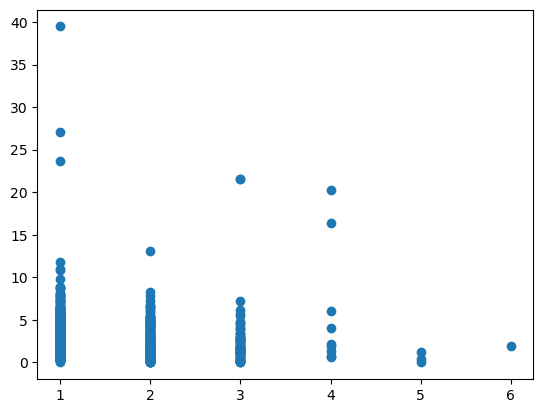

In [23]:
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression 

dummy = median_df_total['n_crops'] 
y = median_df_total['Yield'].astype(float)

plt.scatter(dummy , y)

In [15]:
LinearRegression

sklearn.linear_model._base.LinearRegression

In [ ]:
def IFE(data,target,by='var',model=None,correlation_threshold=0.4,verbose=False,plot=False,waitforinput=False):
  '''
  Iterative Feature Selection.
  by = model or var
  IFE(by='var',correlation_threshold=0.4,verbose=True,plot=True,waitforinput=True)
  '''


  selected_features = []
  while data.shape[1] > 0:
    input() if waitforinput else -1
    if(by=='var'):
      feature_variances = data.var()
      selected_feature = feature_variances.idxmax()
    elif by == 'covar':
      covariances = data.cov()[target].drop(target)
      selected_feature = covariances.abs().idxmax()

    elif(by=='model'):
      model.fit(data,target)
      selected_feature = data.columns[model.feature_importances_.argmax()]
    else:
      raise Exception('Unrecognized value for by parameter')

    selected_features.append(selected_feature)
    print(selected_feature ,"Selected") if verbose else -1

    correlated_features = data.corr()[selected_feature].abs()
    plt.plot(correlated_features) if plot else -1
    plt.show() if plot else -1
    correlated_features = correlated_features[correlated_features > correlation_threshold].index

    print("Correlated Features are ",correlated_features) if verbose else -1
    data = data.drop(correlated_features, axis=1)
  return selected_features

def Copt(by='accuracy',model=-1):
  '''
  Combination optimization
  Take all combinations of columns and fit randomforest
  '''
  if(model==-1):
    raise Exception("You need a model to run Copt.")


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_selection import SelectKBest, f_regression

# Assuming your DataFrame is called df and the target column is named 'target'
# Replace with actual names as needed
df = df.copy()
target_col = 'target'

# Outlier removal using z-score
from scipy.stats import zscore
df = df[(np.abs(zscore(df.select_dtypes(include=[np.number]))) < 3).all(axis=1)]

# Split features and target
X = df.drop(columns=[target_col])
y = df[target_col]

# Feature selection (select top 10 features)
X_selected = SelectKBest(score_func=f_regression, k=10).fit_transform(X, y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

# Models
models = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(),
    "RandomForest": RandomForestRegressor(random_state=42),
    "DecisionTree": DecisionTreeRegressor(random_state=42)
}

results = {}

# Train and evaluate models
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results[name] = {'model': model, 'mse': mse, 'r2': r2, 'y_pred': y_pred}

# Plotting results
plt.figure(figsize=(15, 10))
for i, (name, res) in enumerate(results.items(), 1):
    plt.subplot(2, 2, i)
    sns.scatterplot(x=y_test, y=res['y_pred'], alpha=0.6)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel('True Values')
    plt.ylabel('Predicted Values')
    plt.title(f'{name}\nMSE: {res["mse"]:.2f}, R²: {res["r2"]:.2f}')
plt.tight_layout()
plt.show()


For building a yield prediction model using remote sensing in agriculture, the general features can be grouped into several categories. Below is a comprehensive list of relevant features commonly used, covering spectral, temporal, environmental, and ancillary data. You can include all of these, and then perform feature selection later.

🌾 1. Spectral Indices (from satellite or drone data)
NDVI (Normalized Difference Vegetation Index)

EVI (Enhanced Vegetation Index)

SAVI (Soil Adjusted Vegetation Index)

GNDVI (Green NDVI)

NDWI (Normalized Difference Water Index)

MSAVI (Modified Soil-Adjusted Vegetation Index)

NBR (Normalized Burn Ratio)

RENDVI (Red Edge NDVI)

VARI (Visible Atmospherically Resistant Index)

PRI (Photochemical Reflectance Index)

🛰️ 2. Raw Spectral Bands
(From sensors like Sentinel-2, Landsat, etc.)

Red

Green

Blue

NIR (Near-Infrared)

SWIR1, SWIR2 (Short-Wave Infrared)

Red Edge bands (especially from Sentinel-2)

Thermal Infrared (for stress detection)

📅 3. Temporal Features
(These are per timepoint or summarized over season)

Mean, max, min NDVI over season

NDVI at specific growth stages

Rate of NDVI change

NDVI integral (area under NDVI curve)

Dates of phenological stages (e.g., planting, flowering, maturity)

Days After Planting (DAP)

🌦️ 4. Weather and Climate Data
Rainfall (total, seasonal, monthly)

Temperature (min, max, average)

Growing Degree Days (GDD)

Solar radiation

Humidity

Evapotranspiration (ET)

Soil moisture

Wind speed

🌱 5. Soil and Topographic Data
Soil type/class

Soil organic matter

pH

Soil electrical conductivity

Soil texture (sand, silt, clay)

Topographic features:

Elevation

Slope

Aspect

Topographic Wetness Index (TWI)

🚜 6. Agronomic and Management Data
(if available)

Crop type

Planting date

Harvest date

Fertilizer application (type, amount, date)

Irrigation (method, amount, timing)

Pesticide/fungicide usage

Tillage practices

Seeding rate

🗺️ 7. Location & Spatial Features
Latitude / Longitude

Field boundaries / parcel ID

Distance to water sources

Proximity to roads/markets

🧭 8. Historical Yield Data
Previous years’ yields

Anomalies or trend in yields

Field variability metrics

🧪 9. Other Remote Sensing Derived Products
Canopy temperature (from thermal imagery)

Canopy cover

LAI (Leaf Area Index)

FAPAR (Fraction of Absorbed PAR)